In [6]:
from tensorflow.keras.utils import to_categorical # type: ignore
import numpy as np
import time
import os
from models import *
from Utils import *

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [24]:
(x_train, y_train), (x_test, y_test), end, input_shape = load_data('cifar10')

In [8]:
def train_model(worker_model, dataset, results, worker_id, batch_size):

    start = time.time()
    
    history = worker_model.fit(dataset[0], dataset[1], batch_size=batch_size, epochs=1, validation_data=(x_test, y_test), verbose=0)    
    loss = history.history['loss'][0]

    end = time.time()
    training_time = end - start
    
    results.append((worker_id, training_time, worker_model, loss))

In [9]:
num_workers = 16
batch_size = 32
epochs = 25
beta = [0.2, 0.4, 0.6, 0.8, 1.0]

In [10]:
sample_size = int(len(x_train)*.2)
print(f"For Number of Workers = {4} and Batch Size = {.2*100}% ({sample_size})")
indices = np.random.choice(len(x_train), sample_size, replace=False)
x_subsets, y_subsets = dirichlet_split((x_train[indices], y_train[indices]), num_workers)

model = get_model(resnet18, input_shape, end)
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

loss = []

for global_epoch in range(epochs):

    start_time = time.time()
    results = []    
    models = []
    
    for i in range(4):
        train_model(model, (x_subsets[i], y_subsets[i]), results, i, batch_size)

    # results.sort(key=lambda x: x[1])
    # results = results[:4]
    
    models = [result[2] for result in results]
    logs = [result[3] for result in results]
    model = average_model_weights(models, 'resnet18', end, input_shape)    
    model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
    loss.append(np.mean(logs))
    end_time = time.time()
    total_time_taken = end_time - start_time
    print(f"Global Epoch {global_epoch + 1}/{epochs}: Loss={np.mean(logs)}, Time Taken={total_time_taken}")

print("Training complete.")


For Number of Workers = 4 and Batch Size = 20.0% (10000)
Global Epoch 1/25: Loss=2.1432848274707794, Time Taken=31.864116191864014
Global Epoch 2/25: Loss=1.8809929192066193, Time Taken=29.814584970474243
Global Epoch 3/25: Loss=1.7743494510650635, Time Taken=29.58702278137207
Global Epoch 4/25: Loss=1.6563447713851929, Time Taken=29.958645343780518
Global Epoch 5/25: Loss=1.5949748158454895, Time Taken=29.837442874908447
Global Epoch 6/25: Loss=1.4954493045806885, Time Taken=29.67735457420349
Global Epoch 7/25: Loss=1.438590794801712, Time Taken=30.212409257888794
Global Epoch 8/25: Loss=1.3518529832363129, Time Taken=29.77391505241394
Global Epoch 9/25: Loss=1.306102305650711, Time Taken=29.87060022354126
Global Epoch 10/25: Loss=1.2201892137527466, Time Taken=30.128528594970703
Global Epoch 11/25: Loss=1.1729706227779388, Time Taken=29.725270748138428
Global Epoch 12/25: Loss=1.1096408367156982, Time Taken=30.05831503868103
Global Epoch 13/25: Loss=1.0378116518259048, Time Taken=29.

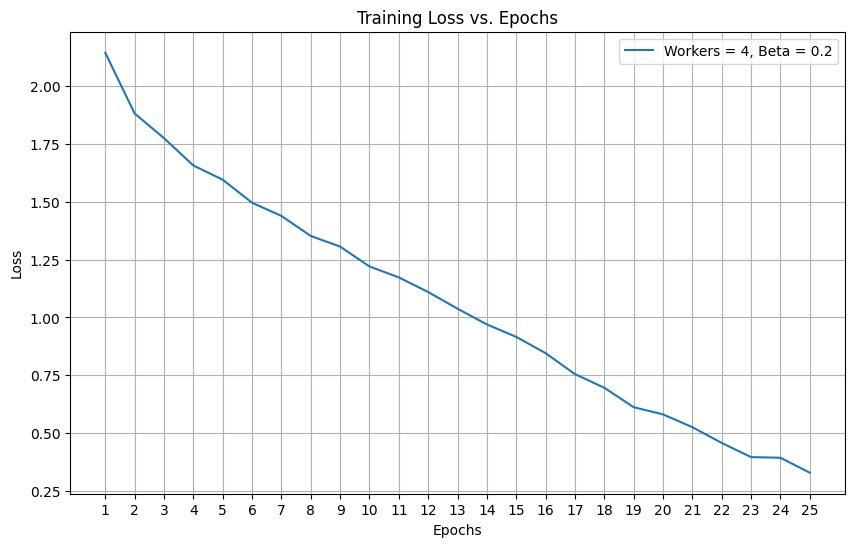

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs+1), loss, label=f'Workers = {4}, Beta = {.2}')

plt.title('Training Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(1, epochs+1))
plt.grid(True, which='both', axis='both')

plt.legend()
plt.show()

In [22]:
s = len(indices)
b_min = np.ceil((7) * s / (7 + 1)) / s
beta = [size for size in beta if size >= b_min]

In [25]:
len(x_train)

50000

In [1]:
import tensorflow as tf

In [2]:
tf.__version__

'2.10.1'